In [ ]:
import os
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')
# Provide the path to the folder in your Drive
folder_path = '/content/drive/MyDrive/CCFD_Delivery/Data'
os.chdir(folder_path)
os.listdir()

Mounted at /content/drive


['pipeline_utils.py',
 'creditcard.csv',
 'resampled_data.pkl',
 '__pycache__',
 'resampled_data_new.pkl',
 'exps',
 'class1_f1_score_plot.png',
 'class1_f1_score_plot_nb4.png',
 'classification_cost_plot_nb4.png',
 'Training_time_nb4.csv',
 'Sampling_Time_nb2.csv',
 'resampled_data_nb2.pkl',
 'performance_metrics_plot_nb2.png',
 'performance_metrics_plot_nb3.png',
 'resampled_data_nb4_cc.pkl',
 'performance_metrics_plot.png']

In [ ]:
import time
import numpy as np
import pickle as pkl
import pandas as pd
from pipeline_utils import save_report, split_data

## Classification Cost

In [ ]:
with open("resampled_data_new.pkl", 'rb') as f:
  resampled_data = pkl.load(f)

In [ ]:
# We need to get Original Amount
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
X_train, X_test, y_train, y_test = split_data(df, 0.2)

(284807, 30)
(284807, 1)

 Train set
[0 1]
[227451    394]
[99.82707542  0.17292458] %

 Test set
[0 1]
[56864    98]
[99.82795548  0.17204452] %


In [ ]:
X_test = pd.DataFrame(X_test)

In [ ]:
X_test.shape

(56962, 30)

In [ ]:
amounts = X_test.iloc[:,-1]

In [ ]:
amounts = np.array(amounts)

In [ ]:
amounts

array([23.  , 11.85, 76.07, ..., 16.39, 19.95, 59.9 ])

In [ ]:
resampled_data['test_amounts'] = amounts

In [ ]:
# pkl.dump(resampled_data, open("resampled_data_nb4_cc.pkl", 'wb'))

In [ ]:
def calculate_missclassification_cost(y_true, y_pred, amounts, admin_cost = 10, batch_size=1000):
    total_cost = 0

    for i in range(0, len(y_true), batch_size):
        batch_y_true = y_true[i:i+batch_size]
        batch_y_pred = y_pred[i:i+batch_size]
        batch_amounts = amounts[i:i+batch_size]

        false_positives = batch_y_pred * (1 - batch_y_true)
        false_negatives = (1 - batch_y_pred) * batch_y_true
        true_positives = batch_y_pred * batch_y_true

        fp_cost = admin_cost * np.sum(false_positives)
        fn_cost = np.sum((false_negatives * batch_amounts))
        tp_cost = np.sum(true_positives)*admin_cost

        total_cost += fp_cost + fn_cost + tp_cost

    return total_cost

## Loading Data from pkl file

In [1]:
import pickle as pkl

In [3]:
resampled_data = pkl.load(open("resampled_data_nb4.pkl", 'rb'))

FileNotFoundError: ignored

In [ ]:
resampled_data.keys()

dict_keys(['X_resampled_ADASYN', 'y_resampled_ADASYN', 'X_resampled_SVMSMOTE', 'y_resampled_SVMSMOTE', 'X_resampled_BorderlineSmote', 'y_resampled_BorderlineSmote', 'X_resampled_ClusterCentroids', 'y_resampled_ClusterCentroids', 'X_resampled_TomekLinks', 'y_resampled_TomekLinks', 'X_train', 'y_train', 'X_test', 'y_test', 'test_amounts'])

## Choose Sampler (SVMSMOTE)

In [ ]:
X_train = resampled_data["X_resampled_SVMSMOTE"]
y_train = resampled_data["y_resampled_SVMSMOTE"]

X_test = resampled_data["X_test"]
y_test = resampled_data["y_test"]

In [ ]:
amounts = resampled_data['test_amounts']

## Classifiers

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.metrics import classification_report_imbalanced
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, matthews_corrcoef

In [ ]:
clfs = {
    "XGBoost": XGBClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "ExtraTreesClassifer": ExtraTreesClassifier(random_state=42)
}

In [ ]:
results_df = pd.DataFrame(columns=["Classifier", "Training_Time"])
classification_costs = {}
f1_scores = {}
recall_scores = {}
precision_scores = {}

for clf_name, clf in clfs.items():
    print('\t' + clf_name)
    start_time = time.time()
    clf.fit(X_train, y_train)
    end_time = time.time()
    print(f"{clf_name} Done!")

    # Append the results to the DataFrame using pd.concat
    new_row = {"Classifier": clf_name, "Training_Time": end_time - start_time}
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


    # Make predictions on the test set
    y_test_pred = clf.predict(X_test)


    y_true = y_test
    y_pred = y_test_pred


    #recall score
    recall= recall_score(y_true, y_pred)
    print ('\t recall score =', recall)
    recall_scores[clf_name] = recall

    precision = precision_score(y_true, y_pred)
    print ('\t precision score =', recall)
    precision_scores[clf_name] = precision

    #accuracy score
    accuracy= accuracy_score(y_true, y_pred)

    #MCC
    MCC = matthews_corrcoef(y_true, y_pred)

    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    # Calculate Area under the curve to display on the plot
    auc= metrics.auc(fpr, tpr)
    # Now, plot the computed values
    classification_cost = calculate_missclassification_cost(y_true, y_pred, amounts)


    #classification report
    report = classification_report_imbalanced(y_true, y_pred, output_dict=True)
    f1_scores[clf_name] = report[1]['f1']
    classification_costs[clf_name] = classification_cost
    df_report = pd.DataFrame(report)
    df_report['Accuracy'] = pd.Series(accuracy, index=df_report.index)
    df_report['AUC'] = pd.Series(auc, index=df_report.index)
    df_report['MCC'] = pd.Series(MCC, index=df_report.index)
    df_report['Classification_Cost'] = pd.Series(classification_cost, index=df_report.index)
    print(df_report)


    #confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm)
    print(df_cm)
    print("="*50)
    print("\n")

    save_report(f"{clf_name}_NB4", df_report, "_CR")
    save_report(f"{clf_name}_NB4", df_cm, "__CM")


results_df.to_csv("Training_time_nb4.csv")

	XGBoost
XGBoost Done!
	 recall score = 0.8775510204081632
	 precision score = 0.8775510204081632
                0          1   avg_pre   avg_rec   avg_spe    avg_f1  \
pre      0.999789   0.834951  0.999505  0.999491  0.877761  0.999497   
rec      0.999701   0.877551  0.999505  0.999491  0.877761  0.999497   
spe      0.877551   0.999701  0.999505  0.999491  0.877761  0.999497   
f1       0.999745   0.855721  0.999505  0.999491  0.877761  0.999497   
geo      0.936637   0.936637  0.999505  0.999491  0.877761  0.999497   
iba      0.888005   0.866573  0.999505  0.999491  0.877761  0.999497   
sup  56864.000000  98.000000  0.999505  0.999491  0.877761  0.999497   

      avg_geo   avg_iba  total_support  Accuracy       AUC       MCC  \
pre  0.936637  0.887968          56962  0.999491  0.979916  0.855732   
rec  0.936637  0.887968          56962  0.999491  0.979916  0.855732   
spe  0.936637  0.887968          56962  0.999491  0.979916  0.855732   
f1   0.936637  0.887968          5696

<ipython-input-14-04e76fbda1f4>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


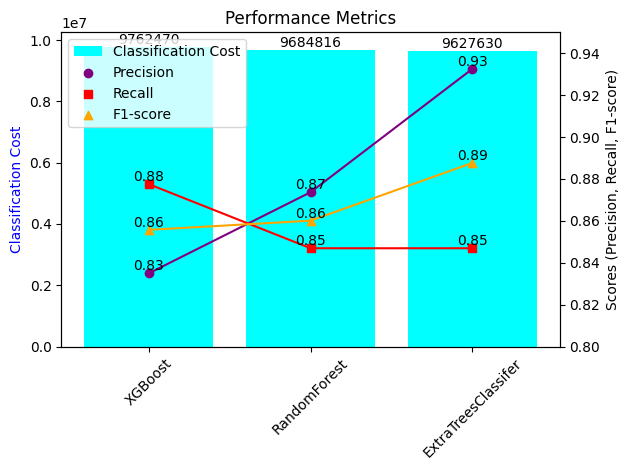

In [ ]:
import matplotlib.pyplot as plt


# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot the Classification Cost as a Bar Chart on the right axis
ax1.bar(classification_costs.keys(), classification_costs.values(), color='cyan', label='Classification Cost')
ax1.set_ylabel('Classification Cost', color='blue')

# Create a twin Axes sharing the xaxis for the left side
ax2 = ax1.twinx()

# Create Scatter Plots for Precision, Recall, and F1-score on the left axis
precision_scatter = ax2.scatter(precision_scores.keys(), precision_scores.values(), color='purple', marker='o', label='Precision')
recall_scatter = ax2.scatter(recall_scores.keys(), recall_scores.values(), color='red', marker='s', label='Recall')
f1_scatter = ax2.scatter(f1_scores.keys(), f1_scores.values(), color='orange', marker='^', label='F1-score')
ax2.set_ylabel('Scores (Precision, Recall, F1-score)', color='black')

# Connect the scatter points with line plots
ax2.plot(precision_scores.keys(), precision_scores.values(), color='purple', linestyle='solid')
ax2.plot(recall_scores.keys(), recall_scores.values(), color='red', linestyle='solid')
ax2.plot(f1_scores.keys(), f1_scores.values(), color='orange', linestyle='solid')

# Set the y-axis limits for precision, recall, and F1-score
ax2.set_ylim(0.80, 0.95)

# Display legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Add title
plt.title('Performance Metrics')

# Rotate x-axis labels for better visibility
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Display the scores on top of each bar
for clf, value in classification_costs.items():
    ax1.text(clf, value, f'{value:.0f}', ha='center', va='bottom', fontsize=10)

# Add text labels to the scatter points for precision, recall, and F1-score
for scatter, scores in zip([precision_scatter, recall_scatter, f1_scatter], [precision_scores, recall_scores, f1_scores]):
    for clf, value in scores.items():
        ax2.text(clf, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

# Adjust layout and save the plot
fig.tight_layout()
plt.savefig('performance_metrics_plot_nb4.png')

# Show the plot
plt.show()
